# Climate Change

The goal of this project is to practice SQL *windows functions*, ascertaining different climate change insights within "Global Land and Ocean Temperatures" dataset in the process. This particular dataset comes from [Kaggle](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByState.csv). The raw data are collected by [Berkeley Earth](https://berkeleyearth.org/data/).

Window functions allow maintaining the values of original table while displaying grouped or summative information alongside in another column. This is why many Data Scientists and Data Engineers frequently use window functions for complex data analysis.


Columns description:

- `Date`: starts in 1850 for average land temperature, max and min land temperatures and global ocean and land temperatures
- `LandAverageTemperature`: global average land temperature in celsius
- `LandAverageTemperatureUncertainty`: the 95% confidence interval around the average
- `LandMaxTemperature`: global average maximum land temperature in celsius
- `LandMaxTemperatureUncertainty`: the 95% confidence interval around the maximum land temperature
- `LandMinTemperature:` global average minimum land temperature in celsius
- `LandMinTemperatureUncertainty`: the 95% confidence interval around the minimum land temperature
- `LandAndOceanAverageTemperature`: global average land and ocean temperature in celsius
- `LandAndOceanAverageTemperatureUncertainty`: the 95% confidence interval around the global average land and ocean temperature

## Data Investigation

Let's start with data imports and data investigation. 

In [1]:
# Basic imports related to analysis
import pandas as pd
import numpy as np 

# Imports related to database management
import sqlite3

# Import for visualisation
import seaborn as sns
from matplotlib import pyplot as plt

Let's see what data our `climate_data.csv` contains. We are going to convert it to `pandas` `DataFrame` and after that create a new SQL database from it.

In [2]:
# Read csv to DataFrame
temps = pd.read_csv("GlobalTemperatures.csv")
temps.head(2)

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1,1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414


While uncertainties are useful information for extended research we won't need them for our short practice, so let's limit our columns to averages, mins, maxes and dates. To make our results more concise, we'll aggregate averages as well as select maximums and minimums by year instead of months. 

In [3]:
# Copy to new DataFrame only relevant columns
temps_avg_min_max = temps[[
    'dt', 
    'LandAverageTemperature', 
    'LandMaxTemperature', 
    'LandMinTemperature', 
    'LandAndOceanAverageTemperature'
    ]].copy().groupby(by=lambda x: temps.iloc[x]['dt'][:4]).agg({ # Aggregate data by year
    'LandAverageTemperature': 'mean',
    'LandMinTemperature': 'min',
    'LandMaxTemperature': 'max',
    'LandAndOceanAverageTemperature': 'mean',
}).reset_index().rename(columns={'index': 'year'})
temps_avg_min_max.head(2)

,year,LandAverageTemperature,LandMinTemperature,LandMaxTemperature,LandAndOceanAverageTemperature
0,1850,7.900667,-3.206,19.233,14.867167
1,1851,8.178583,-3.242,17.361,14.991833


## Database Creation

Now let's write records of this DataFrame to a new table in the database. 

In [4]:
# Create new db
connect = sqlite3.connect('./climate_change.db')

# Create new table in db
temps_avg_min_max.to_sql('Temperatures', connect, if_exists='replace', index=False)

# Create db cursor
cursor = connect.cursor()

To see results in a table view and make visualizations in the future we'll have to convert SQL return results back to `DataFrames`.

In [5]:
def sql(*args, **kwargs):
    cur = cursor.execute(*args, **kwargs)
    return pd.DataFrame(cur.fetchall(), columns=[column_name[0] for column_name in cur.description])

# Display first 5 rows of table
sql('''
    SELECT *
    FROM Temperatures
    LIMIT 2
''')


,year,LandAverageTemperature,LandMinTemperature,LandMaxTemperature,LandAndOceanAverageTemperature
0,1850,7.900667,-3.206,19.233,14.867167
1,1851,8.178583,-3.242,17.361,14.991833


Just in case, let's see if there are any `null`s in our table.

In [6]:
sql('''
    SELECT  
        COUNT(*) - COUNT(year),
        COUNT(*) - COUNT(LandAverageTemperature),
        COUNT(*) - COUNT(LandMaxTemperature),
        COUNT(*) - COUNT(LandMinTemperature),
        COUNT(*) - COUNT(LandAndOceanAverageTemperature)
    FROM Temperatures
''')

,COUNT(*) - COUNT(year),COUNT(*) - COUNT(LandAverageTemperature),COUNT(*) - COUNT(LandMaxTemperature),COUNT(*) - COUNT(LandMinTemperature),COUNT(*) - COUNT(LandAndOceanAverageTemperature)
0,0,0,0,0,0


No `null`s, which is unusual, but we took only recent data, the full dataset consists of measurements dated around 1700s, and there were a lot of `null`s within such old data, because not everything could have been measured correctly using much simpler equipment than stations have today.

## Aggregate and Value Functions

Let’s start by looking at how the temperature changes over time on 1 and 10-year intervals. We'll explore all available variables of the database making separate queries for each variable: `LandAverageTemperature`, `LandMaxTemperature`, `LandMinTemperature`, `LandAndOceanAverageTemperature`. We'll start from "Land Averages".

In [7]:
# Change format of dates and find averages over 1 year and 10 for LandAverageTemperature
avgs = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        LandAverageTemperature AS 'Land Year Average',
        AVG(LandAverageTemperature) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `10 Years Running Average`
    FROM Temperatures;
''')

# Display first 5 rows and last
def top_bottom(avgs, x=5):
    return pd.concat([ avgs.head(x), (avgs.tail(x))])
top_bottom(avgs, 5)

,Year,Land Year Average,10 Years Running Average
0,1850,7.900667,7.900667
1,1851,8.178583,8.039625
2,1852,8.100167,8.059806
3,1853,8.041833,8.055312
4,1854,8.210500,8.086350
161,2011,9.516000,9.554225
162,2012,9.507333,9.547917
163,2013,9.606500,9.556008
164,2014,9.570667,9.580617
165,2015,9.831000,9.593625


In [8]:
# Change format of dates and find averages over 1 year and 10 for LandAndOceanAverageTemperature
avgs_oc = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        LandAndOceanAverageTemperature AS 'Land & Ocean Year Average',
        AVG(LandAndOceanAverageTemperature) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `Land & Ocean 10 Years Running Average`
    FROM Temperatures;
''')

# Display first 5 rows and last
def top_bottom(avgs_oc, x=5):
    return pd.concat([ avgs_oc.head(x), (avgs_oc.tail(x))])
top_bottom(avgs_oc, 5)

,Year,Land & Ocean Year Average,Land & Ocean 10 Years Running Average
0,1850,14.867167,14.867167
1,1851,14.991833,14.929500
2,1852,15.006500,14.955167
3,1853,14.955167,14.955167
4,1854,14.991000,14.962333
161,2011,15.769500,15.814650
162,2012,15.802333,15.811967
163,2013,15.854417,15.814750
164,2014,15.913000,15.830325
165,2015,16.058583,15.848258


In [9]:
# Change format of dates and find maxes over 1 year and 10 for LandMaxTemperature
maxs = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        LandMaxTemperature AS 'Year Maximum',
        MAX(LandMaxTemperature) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `Maximum Temperature over 10 years`
    FROM Temperatures;
''')

# Display first 5 rows and last
top_bottom(maxs, 5)

,Year,Year Maximum,Maximum Temperature over 10 years
0,1850,19.233,19.233
1,1851,17.361,19.233
2,1852,17.795,19.233
3,1853,19.308,19.308
4,1854,20.426,20.426
161,2011,21.320,21.320
162,2012,21.006,21.320
163,2013,20.737,21.320
164,2014,20.790,21.320
165,2015,20.904,21.320


In [10]:
# Change format of dates and find mins over 1 year and 10 for LandMinTemperature
mins = sql('''
    SELECT
        CAST(year AS INTEGER) AS 'Year',
        LandMinTemperature AS 'Year Minimum',
        MIN(LandMinTemperature) OVER (
            ORDER BY year
            ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING
        ) AS `Minimum Temperature over 10 years`
    FROM Temperatures;
''')

# Display first 5 rows and last
top_bottom(mins, 5)

,Year,Year Minimum,Minimum Temperature over 10 years
0,1850,-3.206,-3.206
1,1851,-3.242,-3.242
2,1852,-2.755,-3.242
3,1853,-4.015,-4.015
4,1854,-4.109,-4.109
161,2011,-2.034,-2.383
162,2012,-2.233,-2.383
163,2013,-1.726,-2.383
164,2014,-2.080,-2.383
165,2015,-1.518,-2.383


Let's tidy up our data: make each variable a separate column and each row a separate observation to make visualizations easily. 

In [11]:
avgs_melted=avgs.melt(
      # Column to use as identifier variables
      id_vars='Year',
      # Column name to use for “variable” names/column headers
      var_name='Type',
      # Column name for the values originally in the columns 
      value_name='Value'
      )
# Melt rest of the tables
maxs_melted=maxs.melt(id_vars='Year', var_name='Type', value_name='Value')
mins_melted=mins.melt(id_vars='Year', var_name='Type', value_name='Value')
avgs_oc_melted=avgs_oc.melt(id_vars='Year', var_name='Type', value_name='Value')
# Display "Land Averages" table
avgs_melted

,Year,Type,Value
0,1850,Land Year Average,7.900667
1,1851,Land Year Average,8.178583
2,1852,Land Year Average,8.100167
3,1853,Land Year Average,8.041833
4,1854,Land Year Average,8.210500
...,...,...,...
327,2011,10 Years Running Average,9.554225
328,2012,10 Years Running Average,9.547917
329,2013,10 Years Running Average,9.556008
330,2014,10 Years Running Average,9.580617


Now we are going to visualize results of our queries as separate side by side graphs.

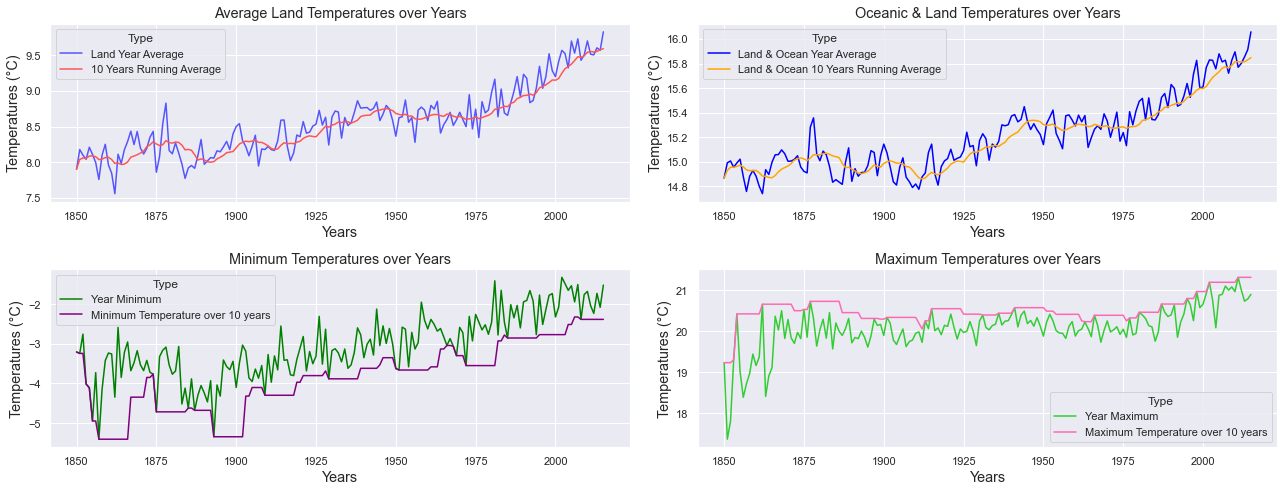

In [33]:
# Set darkgrid for all plots of the project
sns.set(style='darkgrid')

def linears(dfs, palette, titles, rows, columns):
    # Set up grid for plotting.
    fig, sub = plt.subplots(rows, columns, figsize=(18,7), squeeze=False)

    # Draw scatterplots
    for data_set, title, ax, colors in zip(dfs, titles, sub.flatten(), palette):
        sns.lineplot(x=data_set.Year, y=data_set.Value, hue=data_set.Type, palette=colors, legend=True, ax=ax)

        # Set up labels
        ax.set_title(title, fontsize='large')
        ax.set_xlabel('Years', fontsize='large')
        ax.set_ylabel('Temperatures (°C)', fontsize='large')

    fig.tight_layout()
    return plt.show()

linears(
    # Data for plots    
    dfs = (
        avgs_melted,
        avgs_oc_melted,
        mins_melted,
        maxs_melted        
        ),
    # Colors for plots    
    palette = [
        'seismic',
        ['Blue', 'Orange'], 
        ['Green', 'Purple'], 
        ['LimeGreen', 'HotPink']
        ],
    # Title for plots
    titles = (
        'Average Land Temperatures over Years',
        'Oceanic & Land Temperatures over Years',
        'Minimum Temperatures over Years',
        'Maximum Temperatures over Years'
    ), 
    rows=2,
    columns=2
)

Results:

- All graphs show increasing in temperatures over the period from 1850 till 2015. 
- "Average Land Temperatures" and "Oceanic & Land Temperatures" have very similar line pattern but different temperature scales.
- Maximum and minimum temperatures show fluctuations with the higher amplitudes than averages.
- Maximums are showing the steadiest but still clearly perceivable growth. 

Now let's find out when were periods of the most drastic temperature change by comparing current year with previous one. We'll do it only for averages and maximum temperatures because they contain 

In [13]:
change_in_max_avg = sql('''
    SELECT
    CAST(year AS INTEGER) AS 'Year',

    LandAverageTemperature - LAG(LandAverageTemperature, 1, LandAverageTemperature) OVER (
        ORDER by year
    ) AS 'Change in Averages',

    LandMaxTemperature - LAG(LandMaxTemperature, 1, LandMaxTemperature) OVER (
        ORDER BY year
    ) AS 'Change in Maximums'


    FROM Temperatures;
''')

# Make each variable separate column and each row separate observation
max_avg_melted=change_in_max_avg.melt(id_vars='Year', var_name='Type', value_name='Value')

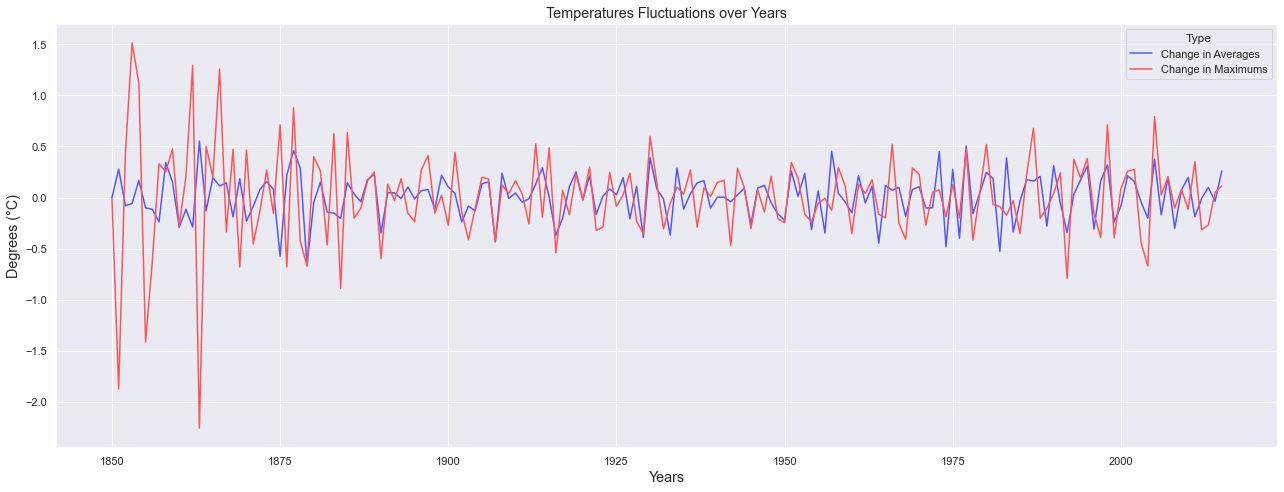

In [14]:
linears(
    # Data for plots    
    dfs = (
        max_avg_melted,       
        ),
    # Colors for plots    
    palette = [
        'seismic',
        ],
    # Title for plots
    titles = (
        'Temperatures Fluctuations over Years',
    ),
    rows=1,
    columns=1
)

Results: 
- Maximums started to reduced their amplitude of temperature fluctuations year-to-year starting roughly from 1890 till 1980. Their edges became closer to `+- 0.5` degree in amplitude. From 1980 though, the fluctuations started increasing again.  
- Averages have roughly the same year to year amplitude over the whole period of observation. 

### Ranking Functions

Are the coldest ranked years recent or historic? 

In [39]:
coldest_rank = sql('''
    SELECT 
    CAST(year AS INTEGER) AS 'YEAR',
    LandMaxTemperature AS 'Year Maximum',
    RANK() OVER(
        ORDER BY LandMaxTemperature
    ) AS RANK
    FROM Temperatures  
''')
# Display first 10 and last 10
top_bottom(coldest_rank, 10)

,YEAR,Year Maximum,RANK
0,1851,17.361,1
1,1852,17.795,2
2,1856,18.386,3
3,1863,18.408,4
4,1857,18.717,5
5,1864,18.909,6
6,1858,18.968,7
7,1855,19.012,8
8,1865,19.111,9
9,1860,19.163,10


What about the warmest temperatures: are they more recent or historic?

In [38]:
warmest_rank = sql('''
    SELECT 
    CAST(year AS INTEGER) AS 'YEAR',
    LandMinTemperature AS 'Year Minimum',
    RANK() OVER(
        ORDER BY LandMinTemperature
    ) AS RANK
    FROM Temperatures  
''')
# Display first 10 and last 10
top_bottom(warmest_rank, 10)

,YEAR,Year Minimum,RANK
0,1857,-5.407,1
1,1893,-5.345,2
2,1855,-4.947,3
3,1875,-4.717,4
4,1887,-4.678,5
5,1885,-4.621,6
6,1883,-4.519,7
7,1891,-4.465,8
8,1862,-4.346,9
9,1895,-4.319,10


Result: rankings by maximum and minimum temperature show that historic temperatures were 2-4 degrees lower on the average than modern ones.

Let’s now write a query that will return the average yearly temperatures in quartiles instead of in rankings.

In [18]:
quartiles = sql('''
    SELECT 
    NTILE(4) OVER(
        ORDER BY LandAverageTemperature ASC
    ) AS 'Quartile',
    CAST(year AS INTEGER) AS 'YEAR',
    LandAverageTemperature AS 'Average Land Temperatures'
    FROM Temperatures
''')
quartiles

,Quartile,YEAR,Average Land Temperatures
0,1,1862,7.558583
1,1,1857,7.758167
2,1,1884,7.773667
3,1,1861,7.846500
4,1,1875,7.859583
...,...,...,...
161,4,2013,9.606500
162,4,2005,9.700917
163,4,2010,9.703083
164,4,2007,9.732167


The resulting table makes more sense if we visualize it via box plots, so let's do that.

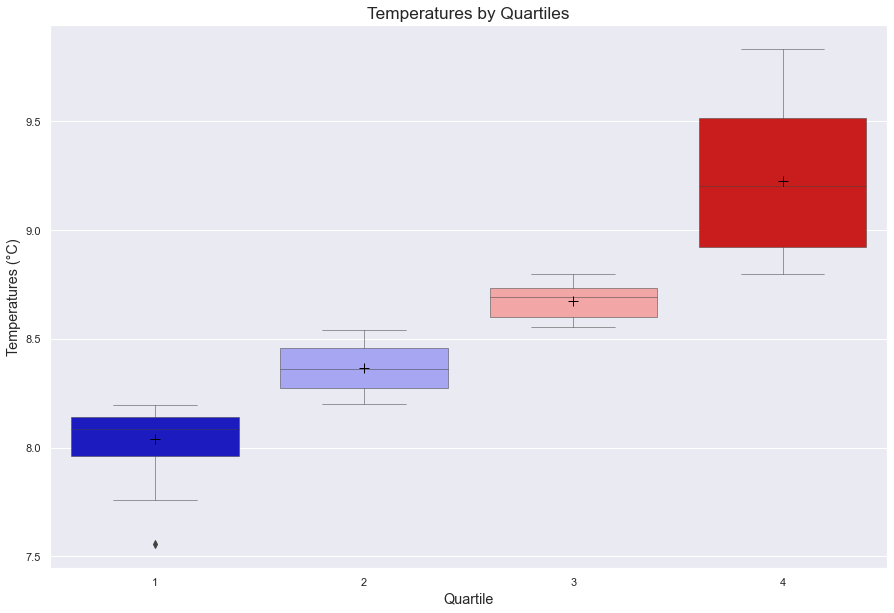

In [37]:
def visualise_boxplot(dataset, features, palette, title, xlabel, ylabel):
    plt.figure(figsize = (15,10))
    ax = sns.boxplot(
        x= dataset[features[0]], 
        y= dataset[features[1]],
        palette=palette, 
        showmeans=True,
        meanprops={"marker": "+",
            "markeredgecolor": "black",
            "markersize": "10"},
        linewidth=0.5)

    # Add descriptions
    ax.set_title(title, fontsize = 'x-large')
    ax.set_xlabel(xlabel, fontsize = 'large')
    ax.set_ylabel(ylabel, fontsize = 'large')
    return plt.show()

# Draw boxplot for inflight_meal
visualise_boxplot(
    quartiles, 
    features=['Quartile', 'Average Land Temperatures'], 
    palette='seismic', 
    title='Temperatures by Quartiles', 
    xlabel='Quartile', 
    ylabel='Temperatures (°C)')

Result: Each quartile has the same number of values within it. The difference in quartile's sizes means they have different amplitudes of average temperature fluctuations. 
- Once again we see more worm temperatures than cold or medium ones, although we can't say at which years it occurs exactly. The hottest fourth quartile has the most significant temperature fluctuations: from `8.5 to 9.5 °C`.
- At the same time the third has the lowest amplitude, but all temperatures within it are also higher (around `8,5 °C`), than those in the previous 2 quartiles.
- The lowest temperatures are collected in the first quartile, some temperature fluctuations are also seemed to present within it. 


## Conclusion

We have created an SQL database using variables of climate dataset. The application of windows function and visualization methods gave us a very clear perception of gradual temperature shift towards higher temperature values from 1850 to 2015. Now we can state that:
- temperature is rising on land and in the ocean;
- maximums as well as minimums steadily become hotter than in historic periods, reducing their amplitudes of temperature fluctuation on year-to-year basis;
- at the same time amplitudes of average temperature fluctuations over recent years became stronger and overall number of warm temperatures is several times higher than number of cold or medium ones. 